# Extended Cox model (recurrent events, time varying features)

In this notebook I implemented the pipeline for the fitting of the realizations of the compensator of the counting process about the hospitalisations.

The data comes from patients affected by heart disease in a follow-up interval of one year from the exit-time of the first hospitalization. 

The following steps are made:

1. Model choice
2. Model fitting
3. Smoothing of baseline Hazard
4. Reconstruction of the patient-specific cumulative Hazards
5. Check of Martingale residuals

In [1]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines
require(latex2exp)

options(repr.plot.width=6, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival
Loading required package: latex2exp


In [2]:
path = '/Users/davide/Documents/universita/tesi/src/fit_compensators/'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data_hospitalisation.RData')

sel_df = hospitalisation_df

In [3]:
# preprocessed data
tail(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,y
22447036,35.0,365.5,0,M,68,1,6
22509166,-0.5,365.5,0,F,87,0,0
23393275,-0.5,18.0,1,F,64,0,0
23393275,18.0,365.5,0,F,64,1,18
23405479,-0.5,33.0,1,M,64,0,0
23405479,33.0,59.0,1,M,64,1,33
23405479,59.0,89.0,1,M,64,2,35
23405479,89.0,365.5,0,M,64,3,41


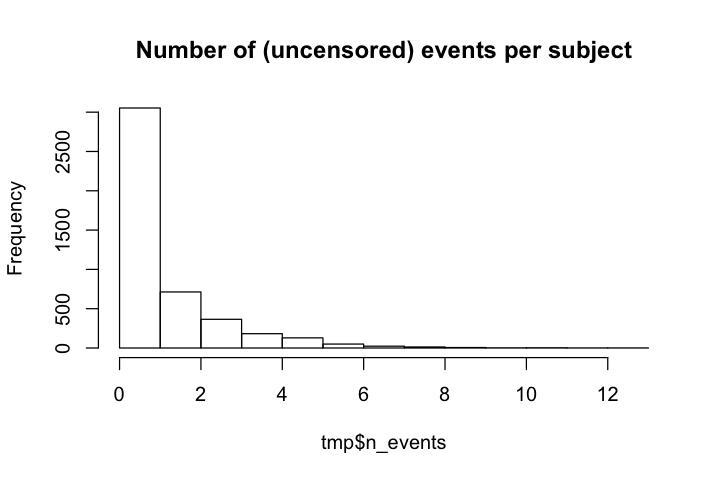

In [4]:
tmp = sel_df[,list('n_events' = max(Nm)),by = 'id']
hist(tmp$n_events, main = 'Number of (uncensored) events per subject')

# Model Choice

## Evaluate goodness of fit 

In [5]:
set.seed(123)
#Randomly shuffle the patients
patients = sample(unique(sel_df$id))
#Create 10 equally size folds
folds <- cut(seq(1,length(patients)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement patients by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid_patients <- patients[validIndexes]
    train_patients <- patients[-validIndexes]
    # Split train, valid
    train = sel_df[id %in% train_patients]
    valid = sel_df[id %in% valid_patients]
    
    # fit
    models = list(
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + y + Nm:y + cluster(id), data = train),
        
        # log(Nm+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + y + log(Nm+1):y + cluster(id), data = train),
        
        # log(y+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        
        # log(Nm+1), log(y+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train)
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        # evaluate martingale residuals at validation events
        valid_model = coxph(model$formula,data = valid, init = model$coefficients, iter.max = 0)
        res = residuals(valid_model, type = "martingale")
        score = mean(abs(res)) # mean absolute residual 
        fold_scores = c(fold_scores,score)
        
        # evaluate concordance probability (not correct in case of time varying coefficients!)
        #prediction = predict(model, newdata = valid)
        #score = survConcordance(Surv(start,stop,status) ~ prediction, data = valid)$concordance[[1]]
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |======================================================================| 100%

In [6]:
# summarize CV scores
mean_scores = colMeans(scores)
best_score = min(mean_scores)
worst_score = max(mean_scores)

In [7]:
# print cv scores
print('****************** Cross validation mean absolute Martingale residual ******************')
cat('\n')
print('|------------------------|--------------------------------------|')
print('|   MEAN ABS. RESIDUAL   |               FORMULA                |')
print('|------------------------|--------------------------------------|')
for(i in 1:length(models)){
    score = mean_scores[i]
    if(score != best_score & score != worst_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3]))
    }else if (score == best_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ BEST MODEL'))
    }else{
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ WORST MODEL'))
    }
}

[1] "****************** Cross validation mean absolute Martingale residual ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|   MEAN ABS. RESIDUAL   |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        0.713           |  age_in + sex + Nm + cluster(id)"
[1] "|        0.724           |  age_in + sex + y + cluster(id)"
[1] "|        0.713           |  age_in + sex + Nm + y + cluster(id)"
[1] "|        0.729           |  age_in + sex + Nm:y + cluster(id)                  <------ WORST MODEL"
[1] "|        0.713           |  age_in + sex + Nm + Nm:y + cluster(id)"
[1] "|        0.724           |  age_in + sex + y + Nm:y + cluster(id)"
[1] "|        0.713           |  age_in + sex + Nm + y + Nm:y + cluster(id)                  <------ BEST MODEL"
[1] "|        0.713           |  age_in + sex + log(Nm + 1) + cluster(id)"
[1] "|        0.713           |  age_in + sex + l

# Fit model

In [4]:
# in order to use some function in the following cells, we build features corresponding to the transformed variables
sel_df[,'sexM':= ifelse(sex == 'M',1,0)]
sel_df[,'Nm_times_y':= Nm*y]

In [6]:
model = coxph(Surv(start,stop,status)~ age_in + sexM + Nm + Nm_times_y + y + cluster(id),data = sel_df)
model
confint(model)

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + sexM + Nm + 
    Nm_times_y + y + cluster(id), data = sel_df)

                 coef  exp(coef)   se(coef)  robust se      z        p
age_in     -0.0043578  0.9956517  0.0011601  0.0011297 -3.857 0.000115
sexM        0.1406686  1.1510431  0.0274414  0.0299819  4.692 2.71e-06
Nm          0.3589998  1.4318965  0.0175362  0.0185142 19.390  < 2e-16
Nm_times_y -0.0023650  0.9976378  0.0003054  0.0004361 -5.423 5.85e-08
y           0.0082765  1.0083108  0.0013518  0.0016437  5.035 4.77e-07

Likelihood ratio test=1089  on 5 df, p=< 2.2e-16
n= 10343, number of events= 5802 

,2.5 %,97.5 %
age_in,-0.006572026,-0.002143554
sexM,0.081905223,0.199431924
Nm,0.322712549,0.395287035
Nm_times_y,-0.003219748,-0.001510340
y,0.005054920,0.011498042


# Compute and smooth baseline Hazards

In [7]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [8]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(-0.5,0,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


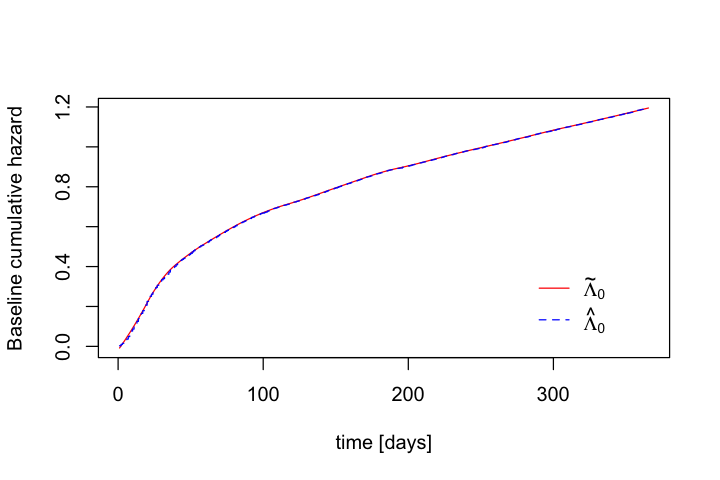

In [49]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time [days]", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

legend(280, 0.4,legend=c(TeX("$\\tilde{\\Lambda}_0"), TeX("$\\hat{\\Lambda}_0")),col=c("red", "blue"), lty=1:2, cex=1,y.intersp=3,box.lty=0)

# Reconstruct patients cumulative Hazards

In [13]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

Warning message in bs(x, knots = knots[2:(length(knots) - 1)], degree = deg, Boundary.knots = c(knots[1], :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”

[1] "Computing coefficients ck"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


In [14]:
head(cumulative_hazard)

id,time,cumhaz
10000243,0,-0.015659122
10000243,1,-0.006969212
10000243,2,0.001865853
10000243,3,0.010846075
10000243,4,0.024146465
10000243,5,0.037658423


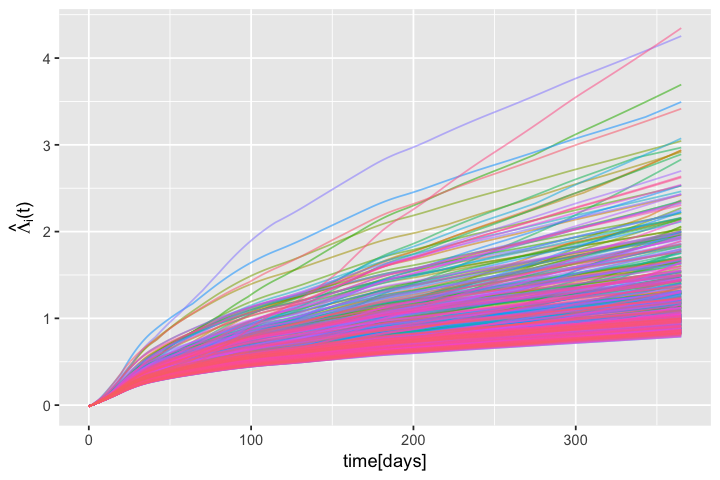

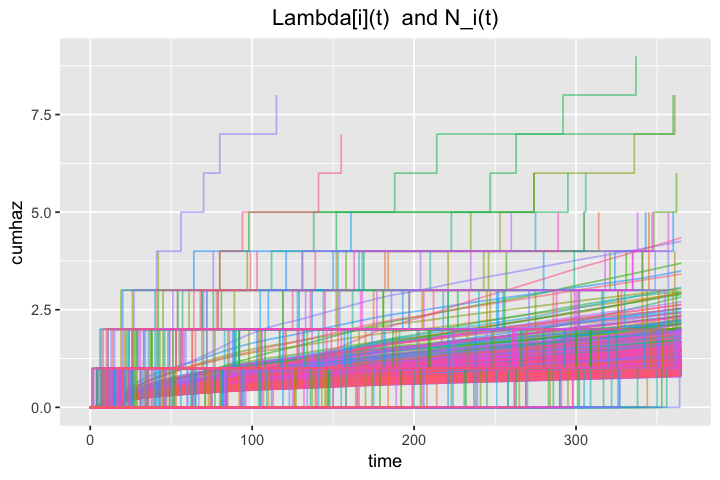

In [56]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),500)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    xlab('time[days]') + 
    ylab(TeX("$\\hat{\\Lambda}_i(t)")) + 
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [16]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards_hospitalisation.RData')

In [55]:
load('../../data/cumulative_hazards_hospitalisation.RData')

# Check Martingale residuals

In [18]:
# compute dataset of daily realizations (only once)
# source('compute_daily_realizations.R')
# daily_realizations_hospitalisation = compute_daily_realizations(sel_df)
# save(daily_realizations_hospitalisation, file = '../../data/daily_realizations_hospitalisation.RData')

In [58]:
# load dataset of daily realizations 
load('../../data/daily_realizations_hospitalisation.RData')
daily_realizations = daily_realizations_hospitalisation

In [59]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

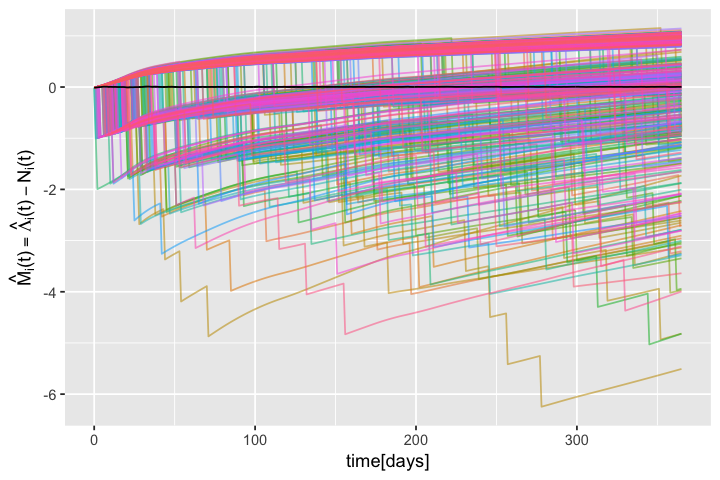

In [63]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    xlab('time[days]') + 
    ylab(TeX("$\\hat{\\M}_i(t) = \\hat{\\Lambda}_i(t) - N_i(t)")) + 
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

The average of the residuals is approximately 0